# Laboratorio 1.1
## Calcolare la similarità nelle definizioni dei 4 concetti del dataset



In [132]:
# python -m IPython notebook
from nltk import word_tokenize, SnowballStemmer
from nltk.corpus import stopwords, words
import string
import pandas as pd
import time
import random
import matplotlib.pylab as plt
start_time = time.time()

snow_stemmer = SnowballStemmer(language='english')

# Crea la variabile stop_words con le stop word e con la punteggiatura
stop_words = set(stopwords.words('english'))
stop_words.update(set(stopwords.words('italian')))
stop_words.update(set(string.punctuation))

def output_message(o=None):
    if o:
        print('\n ------------------------------------------------------------------------------------------------------------------\n Output - ' + str(o) + ' ------------------------------------------------------------------------------------------------------------------ ') 
        print("Tempo di esecuzione: %s secondi. " % round((time.time() - start_time),3))
    else:
        print('\n ------------------------------------------------------------------------------------------------------------------\n Tempo di esecuzione: %s secondi. ---------------------------------------------------------------------------------------------------------------- ' % round((time.time() - start_time),2))

# Pre-Processing
## 1. Definizione della funzione per l'estrazione delle informazioni dalla base di dati

In [133]:
media = {}           # Dictionary che conterrà la media aritmetica della lunghezza di ogni definizione per ogni concetto

def data_extraction(path='dataset/defs.csv'):
    if path == 'dataset/defs.csv':
        df = pd.read_csv(path, header=0)
        df = df.dropna()
        df.drop(['Partecipante'],axis=1,inplace=True)
        data = df.to_dict()

    elif 'dataset/db.csv':
        df = pd.read_csv(path, header=0, sep=',')
        data = df.values.tolist()

    return data

## 2. Definizione della funzione per la pulitura dell'input
La funzione restituirà un dictionary innestato di questo tipo `{Concetto: {utente 0: [definizione tokenizzata e stemmatizzata]}}`

In [134]:
def sort_indexes(data):
    defs = {}

    for concept in data.keys():
        i = 0
        defs.setdefault(concept,{})
        for index in data[concept]:
            defs[concept].setdefault(i, data[concept][index])
            i += 1
    return defs

In [135]:
def pre_processing(data):
    
    if type(data) == list:
        for element in range(len(data)):
            token = word_tokenize(data[element][0].lower())
            token = snow_stemmer.stem(token[0])
            del data[element]
            data.append(token)

    elif type(data) == dict:

        for names in data.keys():
            for index in data[names]:
                data[names][index] = word_tokenize(data[names][index].lower())
                data[names][index] = list(set([snow_stemmer.stem(word) for word in data[names][index] if word not in stop_words or word != "'s"]) - stop_words)

    return data

## Esecuzione delle funzioni dichiarate

In [136]:
start_time = time.time()
# Estrazione dei dati dei concetti in un dictionary
data = sort_indexes(data_extraction())

# Pre-processing dell'input
data = pre_processing(data)

In [137]:
output_message(data)


 ------------------------------------------------------------------------------------------------------------------
 Output - {'Courage': {0: ['properti', 'situat', 'despit', 'allow', 'ani', 'face', 'fear', 'feel'], 1: ['someth', 'fear', 'scar', 'make', 'face', 'us', 'abil', 'unpleas'], 2: ['face', 'thing', 'without', 'fear', 'abil'], 3: ['situat', 'allow', 'face', 'inner', 'thaht', 'strength', 'particular'], 4: ['fear', 'abil', 'control'], 5: ['someth', 'deal', 'unpleas', 'fear', 'abil', 'control'], 6: ['action', 'avoid', 'take', 'riski', 'fear', 'abil'], 7: ['action', 'abili', 'make', 'choic', 'take', 'without', 'fear'], 8: ['fear', 'abl', 'someth'], 9: ['frighten', 'someth', 'despit', 'abil'], 10: ['scare', 'peopl', 'someth', 'abil'], 11: ['situat', 'allow', 'consid', 'danger', 'face', 'us', 'feel'], 12: ['scari', 'someth', 'may', 'abil'], 13: ['make', 'drastic', 'abil', 'choic'], 14: ['fear', 'abil', 'overcom'], 15: ['person', 'characterist', 'take', 'risk'], 16: ['general', 'qual

# Calcolo della similarità
## 1. Definizione della funzione per il calcolo della lunghezza media delle definizioni di un concetto.
La lunghezza media delle definizioni è il rapporto tra la somma della lunghezza di tutte le definizioni e il numero delle definizioni
Output atteso: `{concetto0: 0.58, concetto1: 0.22}`


In [138]:
def average_length_computation(data_dictionary):
    average_length = {}

    for concept in data_dictionary.keys():

        average_words = []
        sentences = []

        for sentence in data_dictionary[concept]:
            new_sentence = word_tokenize(data_dictionary[concept][sentence])


            for token in new_sentence:
                average_words.append(1)
            
            sentences.append(1)
        
        average_length.setdefault(concept, sum(average_words) / len(sentences))

    return average_length      


In [139]:
print(average_length_computation(data_extraction()))

{'Courage': 9.333333333333334, 'Paper': 8.566666666666666, 'Apprehension': 7.533333333333333, 'Sharpener': 7.866666666666666}


## 2. Definizione della funzione per la sovrapposizione lessicale
Si intende definire la sovrapposizione lessicale tramite l'utilizzo della seguente struttura dati:
- `shared_words` sarà un dictionary annidato dove si terrà conto delle volte che una parola è stata utilizzata per ogni definizione di un concetto ecco un esempio del contenuto di questo array associativo: `{'Courage': { 'gatto': [0, 2, 0, 0, 0,..,0]}}` => Questo vuol dire che la parola gatto è stata usata due volte dall'utente in posizione 1.
- Utilizzando `shared_words` verrà calcolato il rapporto (`shared_words_rateo`) tra la frequenza delle parole utilizzate nelle varie definizioni e la quantità di definizioni per il concetto sul quale si sta iterando.

**Sovrapposizione lessicale** (`lexical_overlay`): Verrà restituito il numero delle "parole più utilizzate" nelle definizioni. Con "*parole più utilizzate*" si intendono le parole che sono comparse per almeno il 30% delle volte nelle definizioni del proprio concetto.


In [140]:
def lexical_overlay_computation(data_dictionary):
    defs = {}
    shared_words = {}
    lexical_overlay = {}
    relevant_words = {}

    # Creazione di un nuovo dictionary con gli indici ordinati (quello nella variabile "data" aveva alcuni indici senza definizione)
    for concept in data_dictionary.keys():
        i = 0
        defs.setdefault(concept,{})
        shared_words.setdefault(concept,{})
        for index in data_dictionary[concept]:
            defs[concept].setdefault(i, data_dictionary[concept][index])
            i += 1

    for concept in defs.keys():
        for index in defs[concept]:
            for word in defs[concept][index]:

                # Si avrà, per ogni parola, una lista di zeri composta da tanti elementi quante sono le definizioni
                # Si segna quante volte un utente utilizza una certa parola nella sua definizione
                if word not in shared_words[concept].keys():
                    shared_words[concept][word] = [0] * len(defs[concept].keys())

                shared_words[concept][word][index] += 1

    shared_words_rateo = {}
    # Si contano quanti utenti distinti hanno utilizzato una certa parola in una definizione / il totale delle definizioni
    for concept in shared_words.keys():
        if concept not in shared_words_rateo.keys():
            shared_words_rateo.setdefault(concept, {})

        for word in shared_words[concept]:
            if word not in shared_words_rateo[concept].keys():

                # Per ogni parola si fa il rapporto tra il numero di volte che quella parola è stata utilizzata in tutte le definizioni diviso il numero delle definizioni
                shared_words_rateo[concept].setdefault(word, sum(shared_words[concept][word]) / len(shared_words[concept][word]))
                if word not in relevant_words.keys():
                    relevant_words.setdefault(concept, [])
                
                relevant_words[concept].append([word, sum(shared_words[concept][word])])

            # Le parole più utilizzate vengono inserite nel dictionary di output
            if shared_words_rateo[concept][word] > 0.36:

                if word not in lexical_overlay.keys():
                    lexical_overlay.setdefault(concept, 0)
                lexical_overlay[concept] += 1

        lexical_overlay[concept] = lexical_overlay[concept]
    return [lexical_overlay, relevant_words, shared_words_rateo]

In [141]:
print(lexical_overlay_computation(data)[0])

{'Courage': 2, 'Paper': 3, 'Apprehension': 1, 'Sharpener': 5}


## 3. Definizione della funzione per il calcolo della similarità:
Per similarità si intende il rapporto tra sovrapposizione lessicale e lunghezza media delle definizioni.

In [142]:
def similarity_computation(data_dictionary, lexical_overlay, average_length):
    # Il calcolo della similarità è data dal rapporto tra sovrapposizione lessicale e lunghezza media delle definizioni
    similarity = {}
    for concept in data_dictionary.keys():
        similarity[concept] = round(lexical_overlay[concept] / average_length[concept], 4)
    return similarity

## Esecuzione delle funzioni dichiarate:

In [143]:
# Calcolo della lunghezza media delle definizioni
avg_len = average_length_computation(data_extraction())

# Calcolo della sovrapposizione lessicale
lex_overlay = lexical_overlay_computation(data)[0]

# Calcolo della similarità
similarity = similarity_computation(data, lex_overlay, avg_len)

In [144]:
output_message(similarity)


 ------------------------------------------------------------------------------------------------------------------
 Output - {'Courage': 0.2143, 'Paper': 0.3502, 'Apprehension': 0.1327, 'Sharpener': 0.6356} ------------------------------------------------------------------------------------------------------------------ 
Tempo di esecuzione: 0.251 secondi. 


# Risultati laboratorio 1.1
Di seguito una lista con gli di output del primo esercizio sul calcolo numerico della similarity:
- Coraggio: 0.0291
- Carta: 0.0286
- Inquietudine: 0.0278
- Temperino: 0.0527

___

# Laboratorio 1.2
## Similarity Explanation: spiegazione della similarità numerica.
Si intende spiegare la similarità numerica restituendo in output una lista con le 5 parole maggiormente rilevanti per ogni concetto.
Le 5 parole sono state precedentemente calcolate con la funzione `lexical_overlay_computation()`. La funzione `get_relevant_words` permette di scegliere se ricevere in output il dictionary con tutte le parole più usate o una lista con le 5 parole più usate, o ancora, permette di visualizzare l'output in una tabella

In [145]:
def generate_best_freq(frequencies, keep):

    best_words = []
    scores = []
    temp = [element[0] for element in frequencies]
    temp2 = [element[1] for element in frequencies]
    i = 0
    for element in range(len(temp)):
        if i < keep:
            best_words.append(temp[element])
            scores.append(temp2[element])
            i += 1
        else:
            pass

    return [best_words, scores]

In [146]:
def plot_frequencies(concept, keep=10):

    x = []
    y = []

    # Dictionary con tutte le parole più rilevanti
    relevant_words = lexical_overlay_computation(data)[1]

    i = 0
    # Le parole vengono aggiunte all'interno del dictionary e vengono riordinate
    relevant_words[concept] = sorted(relevant_words[concept], key=itemgetter(1), reverse=True)

    x = generate_best_freq(relevant_words[concept], keep)[0]
    y = generate_best_freq(relevant_words[concept], keep)[1]

    # Data Visualization
    plt.bar(x, y)
    plt.xticks(rotation=30, ha='right', fontsize=8)
    plt.grid(axis='y', alpha=.5)
    plt.title('Parole con maggiore sovrapposizione lessicale', color="#1b0037")

    plt.show()

    return [x, y]

# Esecuzione della funzione dichiarata

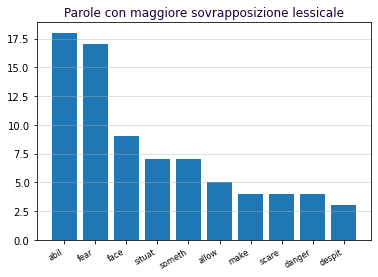

[['abil',
  'fear',
  'face',
  'situat',
  'someth',
  'allow',
  'make',
  'scare',
  'danger',
  'despit'],
 [18, 17, 9, 7, 7, 5, 4, 4, 4, 3]]

In [147]:
plot_frequencies('Courage')

# Laboratorio 1.3
## Word Sense Induction
Si contrappone al Word Sense Disambiguation che è un problema computazionale aperto in cui si deve riconoscere il **senso** di una parola in una frase, siccome una parola può essere utilizzata con accezioni differenti.
Il ***Word Sense Induction*** è invece basato su un meccanismo dove si uniscono due parole (creando una pseudo-word) e si da uno score se quando si itera sul corpus si incontra una delle componenti della pseudoword. Lo score può essere positivo se si ci riferisce a una componente e negativo se ci si riferisce alla seconda componente.

In [148]:
# Restituisce una lista con tutti i token distinte utilizzate
def get_tokens(corpus): 
    words = []
    data = pre_processing(corpus)

    if type(corpus) == dict:
        for concept in data.keys():
            for sentence in corpus[concept]:
                for token in corpus[concept][sentence]:
                    if token != "'s":
                        words.append(token)

    elif type(data) == list:
        for element in data:
            if element[0] != "'s":
                words.append(element[0])

    return list(set(words))

In [149]:
print(get_tokens(data_extraction()))

['veget', 'someth', 'qualcosa', 'handwrit', 'avail', 'brutto', 'tip', 'scar', 'fold', 'resist', 'spiacevol', 'communic', 'abili', 'differ', 'inner', 'preoccup', 'deriv', 'abil', 'accada', 'action', 'sheet', 'veri', 'creat', 'fiber', 'human', 'student', 'surfac', 'upset', 'easili', 'fear', 'piec', 'scari', 'uncofort', 'nervous', 'made', 'print', 'especi', 'expect', 'strength', 'retriev', 'typic', 'strang', 'ventur', 'unexpect', 'character', 'easi', 'obtain', 'order', 'hero', 'work', 'done', 'make', 'scare', 'happen', 'packag', 'withstand', 'sever', 'smooth', 'disturb', 'equip', 'cellulos', 'unpleas', 'flat', 'devic', 'understand', 'draw', 'sad', 'aptitud', 'short', 'tool', 'face', 'abl', 'moral', 'write', 'usual', 'bad', 'difficult', 'stationeri', 'agit', 'refin', 'subject', 'cut', 'consid', 'state', 'compos', 'normal', 'non-relax', 'frighten', 'constant', 'product', 'mark', 'us', 'overcom', 'store', 'sharper', 'characterist', 'anticip', 'end', 'general', 'someon', 'inform', 'status', '

In [150]:
# Restituisce un dictionary con le pseudo-words come chiavi e 0 come valori
def generate_pseudo_words(corpus):
    list_of_tokens = get_tokens(corpus)
    pseudo_words = {}
    scores = {}
    
    for token in range(0, len(list_of_tokens), 2):
        try:
            pseudo_word = list_of_tokens[token] + list_of_tokens[token + 1]
            scores.setdefault(pseudo_word, 0)
            pseudo_words.setdefault(pseudo_word, [list_of_tokens[token], list_of_tokens[token + 1]])

        except IndexError:
            continue
        
    return [scores, pseudo_words]

In [151]:
#print(generate_pseudo_words(data_extraction('dataset/db.csv'))[1])

In [152]:
# Restituisce un nuovo corpus con al posto di alcuni token i token con le pseudo-words, e in più restituisce anche una lista associativa con le pseudo-words e il loro score
def substitute_pseudo_words(corpus, corpus_to_substitute=None):
    corpus = pre_processing(corpus)
    corpus_to_substitute = pre_processing(corpus_to_substitute)
    new_corpus = {}
    pseudo_words_dictionary = generate_pseudo_words(data_extraction('dataset/db.csv'))[0]
    pseudo_words_map = generate_pseudo_words(data_extraction('dataset/db.csv'))[1]


    if type(corpus) == dict:

        for concept in corpus.keys():
            new_corpus.setdefault(concept, {})
            
            for definition_number in corpus[concept]: 

                if definition_number not in new_corpus[concept].keys():
                    new_corpus[concept].setdefault(definition_number, [])
                    
                    
                for token in corpus[concept][definition_number]:
                    keys = list(pseudo_words_map.keys())
                    combined = '\t'.join(keys)
                    if token in combined:
                        pseudo_word = [pseudo_word for pseudo_word in keys if token in pseudo_word][0]

                        # Se la parola la prima parola che compone la pseudo-word è contenuta nella pseudo-word allora si aggiunge 1
                        if token in pseudo_words_map[pseudo_word][0]:
                            pseudo_words_dictionary[pseudo_word] += 1
                        else: 
                            pseudo_words_dictionary[pseudo_word] -= 1   

                        if pseudo_word != '':
                            token = token.replace(token, pseudo_word)

                    new_corpus[concept][definition_number].append(token)

    
    
    elif type(corpus) == list:
        for element in corpus:
            token = element[0]
            keys = list(pseudo_words_dictionary.keys())
            combined = '\t'.join(keys)
            if token in combined:
                pseudo_word = [pseudo_word for pseudo_word in keys if token in pseudo_word][0]

                # Se la parola la prima parola che compone la pseudo-word è contenuta nella pseudo-word allora si aggiunge 1
                try:
                    if token in pseudo_words_map[pseudo_word][0]:
                        pseudo_words_dictionary[pseudo_word] += 1

                except KeyError:
                    pseudo_words_dictionary.setdefault(pseudo_word, 1)

                try:
                    if token in pseudo_words_map[pseudo_word][1]:
                        pseudo_words_dictionary[pseudo_word] -= 1

                except KeyError:
                    pseudo_words_dictionary.setdefault(pseudo_word, -1)

                if pseudo_word != '':
                    token = token.replace(token, pseudo_word)

            for concept in corpus_to_substitute.keys():
                if concept not in new_corpus.keys():
                    new_corpus.setdefault(concept, {})


                for definition_number in corpus_to_substitute[concept]:
                    new_definition = []

                    # Ogni token viene sostituito con la pseudoword che contiene il token
                    for token in corpus_to_substitute[concept][definition_number]:
                        if token in pseudo_word:
                            #print(f"{token} - {pseudo_word[:len(token)]}")

                            token = token.replace(token, pseudo_word)

                        new_definition.append(token)
                    new_corpus[concept].setdefault(definition_number, new_definition)

    return [new_corpus, pseudo_words_dictionary]           

In [153]:
substitute_pseudo_words(data_extraction('dataset/db.csv'), data_extraction())

[{'Courage': {0: ['properti',
    'situat',
    'despit',
    'allow',
    'ani',
    'face',
    'fear',
    'feel'],
   1: ['someth', 'fear', 'scar', 'make', 'face', 'us', 'abil', 'unpleas'],
   2: ['face', 'thing', 'without', 'fear', 'abil'],
   4: ['situat', 'allow', 'face', 'inner', 'thaht', 'strength', 'particular'],
   5: ['fear', 'abil', 'control'],
   6: ['someth', 'deal', 'unpleas', 'fear', 'abil', 'control'],
   7: ['action', 'avoid', 'take', 'riski', 'fear', 'abil'],
   8: ['action', 'abili', 'make', 'choic', 'take', 'without', 'fear'],
   9: ['fear', 'abl', 'someth'],
   10: ['frighten', 'someth', 'despit', 'abil'],
   11: ['scare', 'peopl', 'someth', 'abil'],
   13: ['situat', 'allow', 'consid', 'danger', 'face', 'us', 'feel'],
   14: ['scari', 'someth', 'may', 'abil'],
   15: ['make', 'drastic', 'abil', 'choic'],
   16: ['fear', 'abil', 'overcom'],
   17: ['person', 'characterist', 'take', 'risk'],
   18: ['general', 'qualiti', 'scare', 'danger', 'abl', 'thing'],
   19: 

In [154]:
# Score to probability
def score_converter(score, scores_dictionary):
    temp = []
    rate = 0.00

    for value in scores_dictionary.values():
        temp.append(value)
    
    pos_max_score = max(temp)
    neg_max_score = min(temp)

    # Percentuale di quanto lo score è positivo (1.0 se è uguale al massimo)
    if score > 0:
        rate = score / pos_max_score

    elif score < 0:
        # Percentuale di quanto lo score è negativo (1.0 se è uguale al massimo)
        rate = score / neg_max_score
        
    rate = round(rate, 2)
    return rate


In [155]:
score_converter(-10, substitute_pseudo_words(data_extraction('dataset/db.csv'), data_extraction())[1])

0.14

In [156]:
def wsi(target_corpus, scores, pseudo_words):

    for concept in target_corpus.keys():
        for index in target_corpus[concept]:
            for token_index in range(len(target_corpus[concept][index])):
                token = target_corpus[concept][index][token_index]

                if token in scores.keys():
                    pseudo_word = pseudo_words[token]

                    score = scores[token]

                    if score > 0:
                        target_corpus[concept][index][token_index] = token.replace(token, pseudo_word[0]) 

                    elif score == 0:
                        random_index = random.randint(0, 1)
                        target_corpus[concept][index][token_index] = token.replace(token, pseudo_word[random_index]) 

                    else: 
                        target_corpus[concept][index][token_index] = token.replace(token, pseudo_word[1]) 

    return target_corpus

In [157]:
def wsi2(target_corpus, scores, pseudo_words):

    for concept in target_corpus.keys():
        for index in target_corpus[concept]:
            for token_index in range(len(target_corpus[concept][index])):
                token = target_corpus[concept][index][token_index]

                if token in scores.keys():
                    pseudo_word = pseudo_words[token]

                    score = scores[token]

                    rate = score_converter(score, substitute_pseudo_words(data_extraction())[1])
                    rnd = random.randint(0.00, 1.00)

                    if score > 0:
                        if rate > rnd:
                            target_corpus[concept][index][token_index] = token.replace(token, pseudo_word[0]) 
                        else:
                            target_corpus[concept][index][token_index] = token.replace(token, pseudo_word[1]) 

                    elif score == 0:
                        random_index = random.randint(0, 1)
                        target_corpus[concept][index][token_index] = token.replace(token, pseudo_word[random_index]) 

                    else: 
                        if rate > rnd:
                            target_corpus[concept][index][token_index] = token.replace(token, pseudo_word[0]) 
                        else:
                            target_corpus[concept][index][token_index] = token.replace(token, pseudo_word[1]) 

    return target_corpus

In [158]:
def eval(wsi_corpus, real_corpus):
    real_corpus = pre_processing(real_corpus)
    right_previsions = 0
    total = 0
    for concept in real_corpus.keys():
        for index in real_corpus[concept]:
            for token_index in range(len(real_corpus[concept][index])):
                token = real_corpus[concept][index][token_index]
                
                if token == wsi_corpus[concept][index][token_index]:
                    right_previsions += 1
                    
                total += 1
    accuracy = right_previsions / total

    return accuracy

In [159]:
# Main
input_corpus = substitute_pseudo_words(data_extraction())[0]

scores = substitute_pseudo_words(data_extraction('dataset/db.csv'), data_extraction())[1]

pseudo_words = generate_pseudo_words(data_extraction('dataset/db.csv'))[1]

wsi_corpus = wsi2(input_corpus, scores, pseudo_words)

accuracy = eval(wsi_corpus, data_extraction())

In [160]:
print(round(accuracy, 2))

0.77
